In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import copy
import time
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
import torch
import random
import csv
import copy
import time
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score


In [2]:
image_path = ["data"+i+"/data"+i+"/CameraRGB" for i in ['A','B','C','D']]
mask_path = ["data"+i+"/data"+i+"/CameraSeg" for i in ['A', 'B','C','D']]

In [3]:
image_path

['dataA/dataA/CameraRGB',
 'dataB/dataB/CameraRGB',
 'dataC/dataC/CameraRGB',
 'dataD/dataD/CameraRGB']

In [4]:
import torch
torch.cuda.empty_cache()

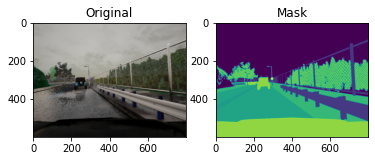

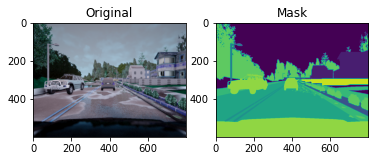

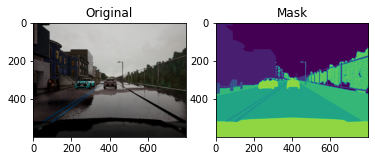

In [5]:
def display_random_images(n=3):
    """
    Display random images with their masks.

    Args:
        n (int): Number of random images to display (default: 3).
    """
    for i in range(n):
        # Generate a random index between 0 and 3
        index = random.randint(0, 3)        
        
        # Select a random image path and mask path using the index
        random_image_path = image_path[index]
        random_mask_path = mask_path[index]
        
        # Choose a random image from the selected image path
        random_image = random.choice(os.listdir(random_image_path))
        
        # Read the random image and its corresponding mask
        image = cv2.imread(os.path.join(random_image_path, random_image))
        mask = cv2.imread(os.path.join(random_mask_path, random_image))
        
        # Display the original image and mask side by side
        fig, arr = plt.subplots(1, 2)
        arr[0].imshow(image)
        arr[0].set_title('Original')
        arr[1].imshow(mask[:, :, 2])
        arr[1].set_title('Mask')      
        
        # Show the plot
        plt.show()

# Display 3 random images with their masks
display_random_images(3)


In [6]:
class CustomDataset(Dataset):
    def __init__(self, img_dirs, mask_dirs, transform=None):
        self.img_dirs = img_dirs
        self.mask_dirs = mask_dirs
        self.transform = transform
        self.image_names = []
        self.mask_names = []
        
        # Load images and masks from directories
        if isinstance(self.img_dirs, list):
            for img_dir, mask_dir in zip(img_dirs, mask_dirs):
                self._load_images_and_masks(img_dir, mask_dir)
        else:
            self._load_images_and_masks(self.img_dirs, self.mask_dirs)
    
    def _load_images_and_masks(self, img_dir, mask_dir):
        # Iterate over filenames in the directory
        for filename in os.listdir(img_dir):
            img_path = os.path.join(img_dir, filename)
            mask_path = os.path.join(mask_dir, filename)
            self.image_names.append(img_path)
            self.mask_names.append(mask_path)
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_path = self.image_names[idx]
        image = cv2.imread(img_path)
        mask_path = self.mask_names[idx]
        mask = cv2.imread(mask_path)
        
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            # Apply transformations to image and mask
            sample['image'] = self.transform(sample['image'])
            sample['mask'] = self.transform(sample['mask'])
        
        return sample

def dataload():
    # Define data transformations for Train and Test
    data_transforms = {
        'Train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ]),
        'Test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
    }
    
    image_datasets = {
        'Train': CustomDataset(image_path[:-1], mask_path[:-1], transform=data_transforms['Train']),
        'Test': CustomDataset(image_path[-1], mask_path[-1], transform=data_transforms['Test'])
    }
    
    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=1)
        for x in ['Train', 'Test']
    }
    
    return dataloaders, image_datasets

dataloaders, image_datasets = dataload()

In [ ]:
## Resnet 101 Backbone

In [7]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Tanh activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model  
model = createDeepLabv3(3)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
        super(ConvolutionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation_rate, padding=padding, bias=use_bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.activation(x)
        return x

class DilatedSpatialPyramidPooling(nn.Module):
    def __init__(self, in_channels):
        super(DilatedSpatialPyramidPooling, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1x1 = ConvolutionBlock(in_channels, in_channels, kernel_size=1, use_bias=True)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.conv_out_1 = ConvolutionBlock(in_channels, in_channels, kernel_size=1, dilation_rate=1)
        self.conv_out_6 = ConvolutionBlock(in_channels, in_channels, kernel_size=3, dilation_rate=6)
        self.conv_out_12 = ConvolutionBlock(in_channels, in_channels, kernel_size=3, dilation_rate=12)
        self.conv_out_18 = ConvolutionBlock(in_channels, in_channels, kernel_size=3, dilation_rate=18)

    def forward(self, x):
        out_pool = self.avg_pool(x)
        out_pool = self.conv1x1(out_pool)
        out_pool = self.upsample(out_pool)

        out_1 = self.conv_out_1(x)
        out_6 = self.conv_out_6(x)
        out_12 = self.conv_out_12(x)
        out_18 = self.conv_out_18(x)

        x = torch.cat([out_pool, out_1, out_6, out_12, out_18], dim=1)
        output = self.conv1x1(x)
        return output

class DeeplabV3(nn.Module):
    def __init__(self, image_size, num_classes):
        super(DeeplabV3, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.model_input = nn.Sequential(*list(resnet50.children())[:7])
        self.dsp_pooling = DilatedSpatialPyramidPooling(2048)

        self.input_a = nn.Upsample(size=(image_size // 4, image_size // 4), mode='bilinear', align_corners=False)
        self.input_b = nn.Sequential(
            *list(resnet50.children())[4][:7],
            ConvolutionBlock(512, 48, kernel_size=1)
        )

        self.concat = nn.Sequential(ConvolutionBlock(2048 + 48, 256), ConvolutionBlock(256, 256))
        self.upsample = nn.Upsample(size=(image_size, image_size), mode='bilinear', align_corners=False)
        self.conv_out = nn.Conv2d(256, num_classes, kernel_size=1, padding="same")

    def forward(self, x):
        x = self.model_input(x)
        x = self.dsp_pooling(x)

        input_a = self.input_a(x)
        input_b = self.input_b(x)

        x = torch.cat([input_a, input_b], dim=1)
        x = self.concat(x)
        x = self.upsample(x)
        output = self.conv_out(x)
        return output

img_height = 256
img_width = 256
num_channels = 3
n_classes = 23

model1 = DeeplabV3(img_height, num_classes=n_classes)
print(model1)


DeeplabV3(
  (model_input): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [9]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()
            
            data_iterator = tqdm(dataloaders[phase], desc=f'{phase} Phase', unit='batch')
            
            for sample in data_iterator:
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

#         for field in fieldnames[3:]:
#             batchsummary[field] = np.mean(batchsummary[field])

#         with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
#             writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#             writer.writerow(batchsummary)

        if phase == 'Test' and loss < best_loss:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

    model.load_state_dict(best_model_wts)
    return model

epochs = 20
bpath = ""
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
metrics = {}

trained_model = train_model(model, criterion, dataloaders, optimizer, metrics, bpath=bpath, num_epochs=epochs)

torch.save(trained_model, os.path.join(bpath, f'{epochs}epochs_resnet101_weights.pt'))


Epoch 1/20
----------


Train Phase:   0%|          | 0/750 [00:00<?, ?batch/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Test Phase: 100%|██████████| 250/250 [00:36<00:00,  6.82batch/s]


Epoch 2/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.44batch/s]


Epoch 3/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.65batch/s]


Epoch 4/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.59batch/s]


Epoch 5/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.70batch/s]


Epoch 6/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.50batch/s]


Epoch 7/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.47batch/s]


Epoch 8/20
----------


Test Phase: 100%|██████████| 250/250 [00:36<00:00,  6.76batch/s]


Epoch 9/20
----------


Test Phase: 100%|██████████| 250/250 [00:39<00:00,  6.39batch/s]


Epoch 10/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.45batch/s]


Epoch 11/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.58batch/s]


Epoch 12/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.71batch/s]


Epoch 13/20
----------


Test Phase: 100%|██████████| 250/250 [00:34<00:00,  7.17batch/s]


Epoch 14/20
----------


Test Phase: 100%|██████████| 250/250 [00:36<00:00,  6.93batch/s]


Epoch 15/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.49batch/s]


Epoch 16/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.56batch/s]


Epoch 17/20
----------


Test Phase: 100%|██████████| 250/250 [00:36<00:00,  6.88batch/s]


Epoch 18/20
----------


Test Phase: 100%|██████████| 250/250 [00:35<00:00,  7.06batch/s]


Epoch 19/20
----------


Test Phase: 100%|██████████| 250/250 [00:40<00:00,  6.24batch/s]


Epoch 20/20
----------


Test Phase: 100%|██████████| 250/250 [00:41<00:00,  5.97batch/s]


Training complete in 96m 29s


In [37]:
model_path = "dataA/resnet101.pt"

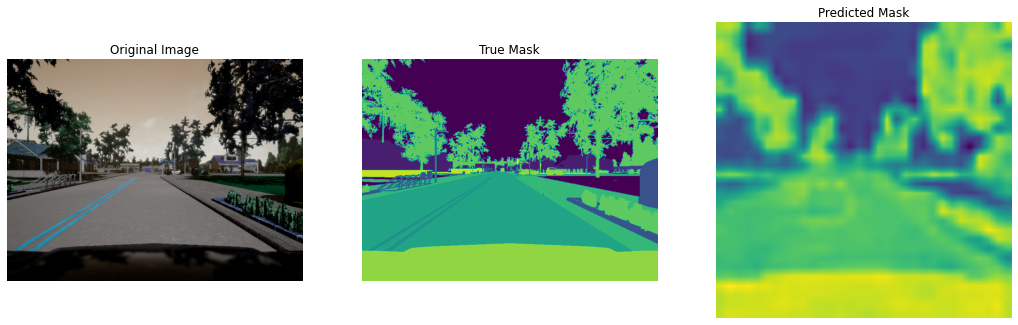

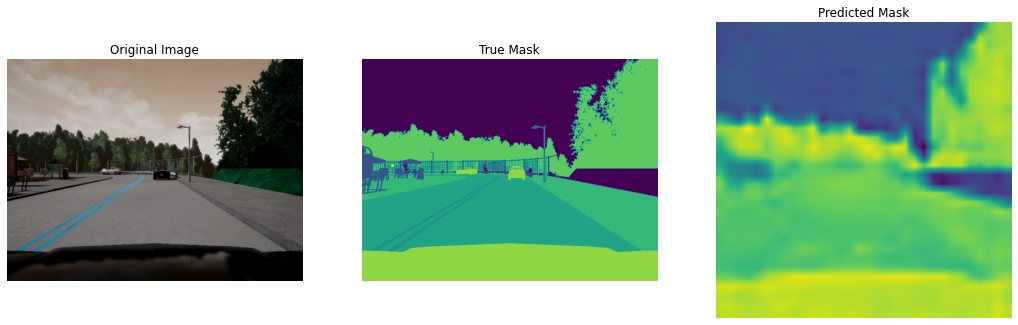

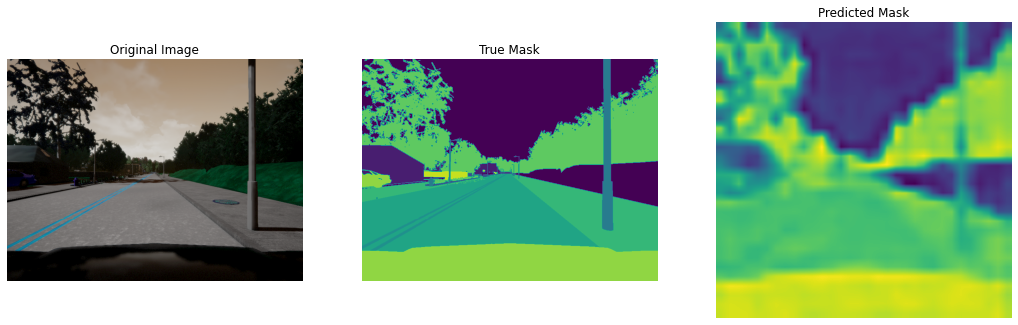

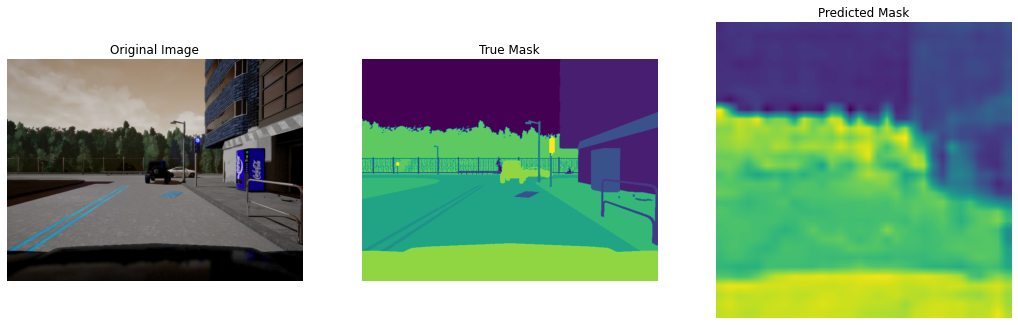

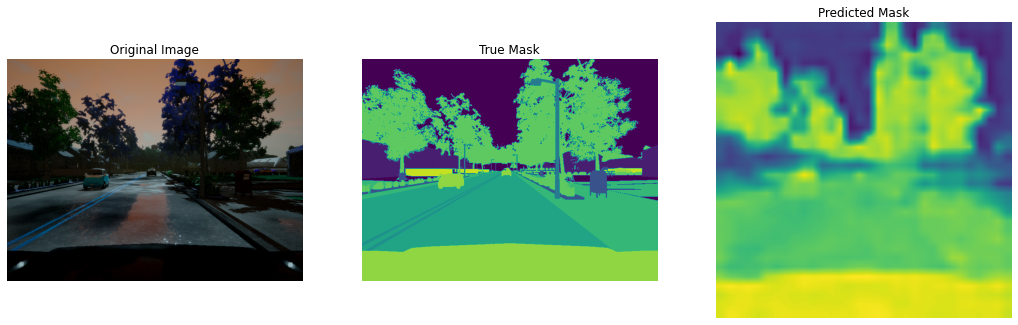

Average IOU score: 0.7549774169921875
Average Dice coefficient: 0.8597252779341922


In [45]:
import random
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def dice_coefficient(true_mask, predicted_mask):
    true_mask = true_mask.astype(bool)
    predicted_mask = predicted_mask.astype(bool)
    intersection = np.logical_and(true_mask, predicted_mask)
    dice = (2.0 * np.sum(intersection)) / (np.sum(true_mask) + np.sum(predicted_mask))
    return dice

def display_mask(model, image_path, mask_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    iou_scores = []  # List to store IOU scores
    dice_scores = []  # List to store Dice coefficients

    for _ in range(5):
        i = random.randint(0, 3)
        img_path = image_path[i]
        mk_path = mask_path[i]

        img_name = random.choice(os.listdir(img_path))

        img = cv2.imread(os.path.join(img_path, img_name))
        mask = cv2.imread(os.path.join(mk_path, img_name))

        original_image = cv2.resize(img, (256, 256), cv2.INTER_AREA).transpose(2, 0, 1)
        original_image = original_image.reshape(1, 3, original_image.shape[1], original_image.shape[2])
        with torch.no_grad():
            if torch.cuda.is_available():
                outputs = model(torch.from_numpy(original_image).to(device).type(torch.cuda.FloatTensor) / 255)
            else:
                outputs = model(torch.from_numpy(original_image).to(device).type(torch.FloatTensor) / 255)

        predicted_mask = outputs['out'].cpu().detach().numpy()[0]
        predicted_mask = predicted_mask.transpose(1, 2, 0)[:, :, 2]

        # Resize true mask to match predicted mask dimensions
        true_mask = cv2.resize(mask, (256, 256), cv2.INTER_AREA)[:, :, 2]

        # Calculate IOU
        true_mask = true_mask.astype(bool)
        intersection = np.logical_and(true_mask, predicted_mask)
        union = np.logical_or(true_mask, predicted_mask)
        iou = np.sum(intersection) / np.sum(union)
        iou_scores.append(iou)

        # Calculate Dice coefficient
        dice = dice_coefficient(true_mask, predicted_mask)
        dice_scores.append(dice)

        fig, arr = plt.subplots(1, 3, figsize=(18, 6))
        arr[0].imshow(img)
        arr[0].set_title('Original Image')
        arr[0].axis('off')
        arr[1].imshow(mask[:, :, 2])
        arr[1].set_title('True Mask')
        arr[1].axis('off')
        arr[2].imshow(predicted_mask)
        arr[2].set_title('Predicted Mask')
        arr[2].axis('off')

        plt.show()

    # Print average IOU score and Dice coefficient
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    print("Average IOU score:", avg_iou)
    print("Average Dice coefficient:", avg_dice)

# Run the display_mask function with the model, image_path, and mask_path
display_mask(model, image_path, mask_path)


In [ ]:
## Resnet 50 backbone

In [14]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet50(
        pretrained=True, progress=True)
    # Added a Tanh activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model  
model = createDeepLabv3(3)

In [15]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()
            
            data_iterator = tqdm(dataloaders[phase], desc=f'{phase} Phase', unit='batch')
            
            for sample in data_iterator:
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs['out'], masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

#         for field in fieldnames[3:]:
#             batchsummary[field] = np.mean(batchsummary[field])

#         with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
#             writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#             writer.writerow(batchsummary)

        if phase == 'Test' and loss < best_loss:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    

    model.load_state_dict(best_model_wts)
    return model

epochs = 20
bpath = ""
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
metrics = {}

trained_model = train_model(model, criterion, dataloaders, optimizer, metrics, bpath=bpath, num_epochs=epochs)

torch.save(trained_model, os.path.join(bpath, f'{epochs}epochs_resnet50_weights.pt'))


Epoch 1/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.53batch/s]


Epoch 2/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.52batch/s]


Epoch 3/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.75batch/s]


Epoch 4/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.59batch/s]


Epoch 5/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.73batch/s]


Epoch 6/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.73batch/s]


Epoch 7/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.60batch/s]


Epoch 8/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.59batch/s]


Epoch 9/20
----------


Test Phase: 100%|██████████| 250/250 [00:36<00:00,  6.80batch/s]


Epoch 10/20
----------


Test Phase: 100%|██████████| 250/250 [00:40<00:00,  6.25batch/s]


Epoch 11/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.61batch/s]


Epoch 12/20
----------


Test Phase: 100%|██████████| 250/250 [00:36<00:00,  6.91batch/s]


Epoch 13/20
----------


Test Phase: 100%|██████████| 250/250 [00:41<00:00,  6.04batch/s]


Epoch 14/20
----------


Test Phase: 100%|██████████| 250/250 [00:39<00:00,  6.35batch/s]


Epoch 15/20
----------


Test Phase: 100%|██████████| 250/250 [00:40<00:00,  6.17batch/s]


Epoch 16/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.65batch/s]


Epoch 17/20
----------


Test Phase: 100%|██████████| 250/250 [00:37<00:00,  6.60batch/s]


Epoch 18/20
----------


Test Phase: 100%|██████████| 250/250 [00:38<00:00,  6.51batch/s]


Epoch 19/20
----------


Test Phase: 100%|██████████| 250/250 [00:40<00:00,  6.23batch/s]


Epoch 20/20
----------


Test Phase: 100%|██████████| 250/250 [00:39<00:00,  6.29batch/s]


Training complete in 68m 57s


In [46]:
model_path = "20epochs_resnet50_weights.pt"

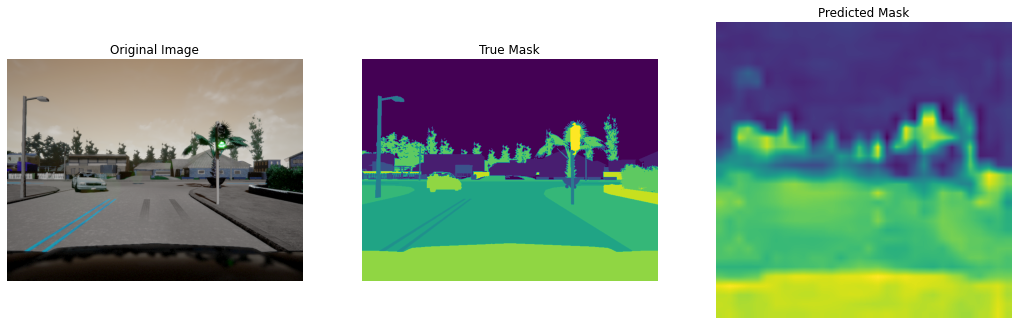

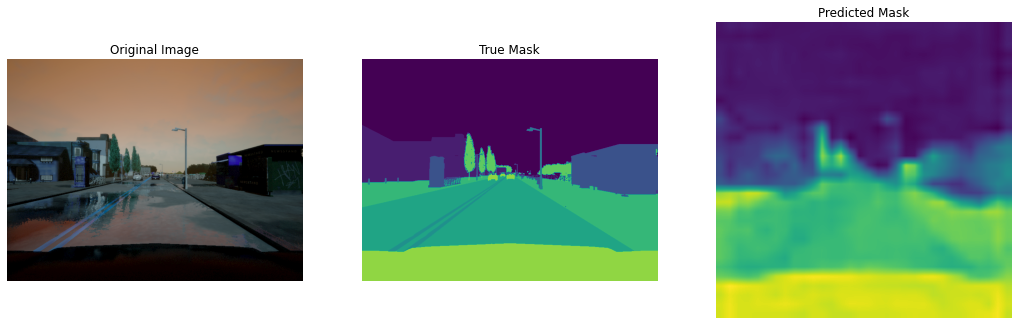

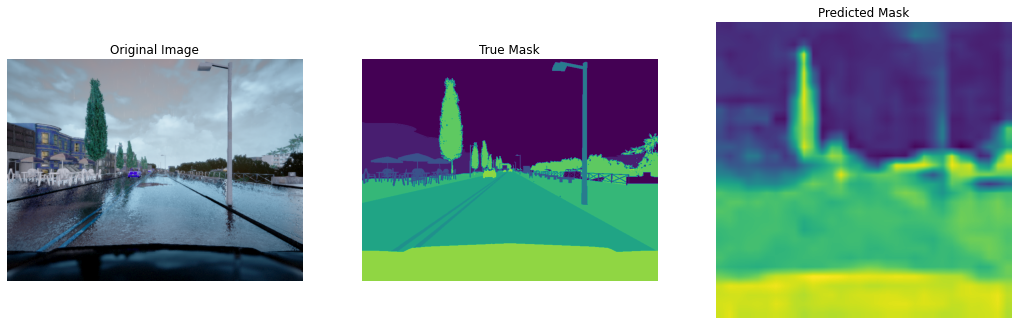

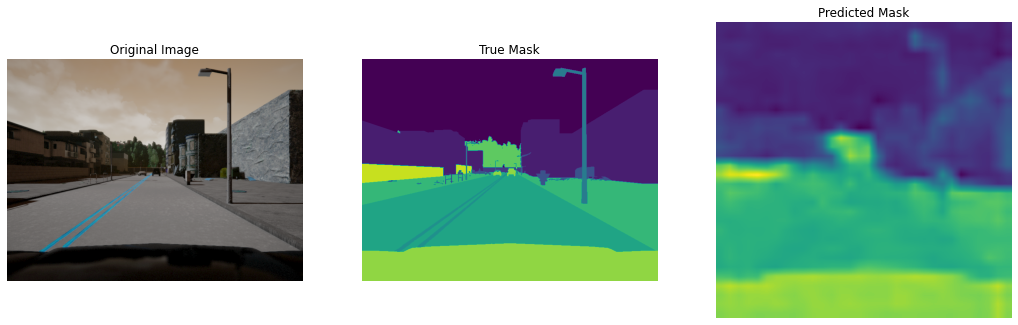

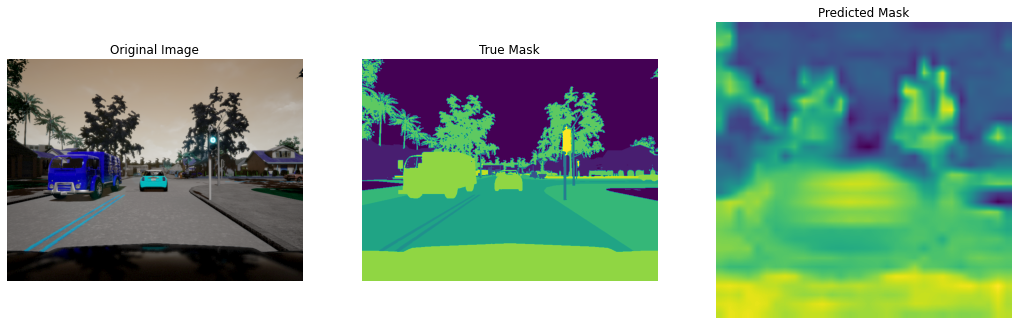

Average IOU score: 0.6453704833984375
Average Dice coefficient: 0.7835526791949533


In [47]:
import random
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def dice_coefficient(true_mask, predicted_mask):
    true_mask = true_mask.astype(bool)
    predicted_mask = predicted_mask.astype(bool)
    intersection = np.logical_and(true_mask, predicted_mask)
    dice = (2.0 * np.sum(intersection)) / (np.sum(true_mask) + np.sum(predicted_mask))
    return dice

def display_mask(model, image_path, mask_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    iou_scores = []  # List to store IOU scores
    dice_scores = []  # List to store Dice coefficients

    for _ in range(5):
        i = random.randint(0, 3)
        img_path = image_path[i]
        mk_path = mask_path[i]

        img_name = random.choice(os.listdir(img_path))

        img = cv2.imread(os.path.join(img_path, img_name))
        mask = cv2.imread(os.path.join(mk_path, img_name))

        original_image = cv2.resize(img, (256, 256), cv2.INTER_AREA).transpose(2, 0, 1)
        original_image = original_image.reshape(1, 3, original_image.shape[1], original_image.shape[2])
        with torch.no_grad():
            if torch.cuda.is_available():
                outputs = model(torch.from_numpy(original_image).to(device).type(torch.cuda.FloatTensor) / 255)
            else:
                outputs = model(torch.from_numpy(original_image).to(device).type(torch.FloatTensor) / 255)

        predicted_mask = outputs['out'].cpu().detach().numpy()[0]
        predicted_mask = predicted_mask.transpose(1, 2, 0)[:, :, 2]

        # Resize true mask to match predicted mask dimensions
        true_mask = cv2.resize(mask, (256, 256), cv2.INTER_AREA)[:, :, 2]

        # Calculate IOU
        true_mask = true_mask.astype(bool)
        intersection = np.logical_and(true_mask, predicted_mask)
        union = np.logical_or(true_mask, predicted_mask)
        iou = np.sum(intersection) / np.sum(union)
        iou_scores.append(iou)

        # Calculate Dice coefficient
        dice = dice_coefficient(true_mask, predicted_mask)
        dice_scores.append(dice)

        fig, arr = plt.subplots(1, 3, figsize=(18, 6))
        arr[0].imshow(img)
        arr[0].set_title('Original Image')
        arr[0].axis('off')
        arr[1].imshow(mask[:, :, 2])
        arr[1].set_title('True Mask')
        arr[1].axis('off')
        arr[2].imshow(predicted_mask)
        arr[2].set_title('Predicted Mask')
        arr[2].axis('off')

        plt.show()

    # Print average IOU score and Dice coefficient
    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    print("Average IOU score:", avg_iou)
    print("Average Dice coefficient:", avg_dice)

# Run the display_mask function with the model, image_path, and mask_path
display_mask(model, image_path, mask_path)
